c:\Users\lmacl\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


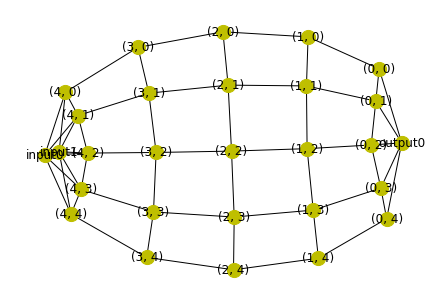

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import networkx as nx
import matplotlib.pyplot as plt
import torch

height = 5
width = 5
hidden_dim = 1
total_hidden_dim = hidden_dim + 3 #hidden data + type

# type_dict = {"hidden": 0, "input": 1, "output": 2}
type_dict = {"hidden": [1, 0, 0], "input": [0, 1, 0], "output": [0, 0, 1]}

#networkx create 2d grid graph, all nodes have [0] as node data
G = nx.grid_2d_graph(height, width)

for node in G.nodes():
    G.nodes[node]['data'] = torch.rand(hidden_dim)
    G.nodes[node]['is_hidden'] = torch.tensor([1])
    G.nodes[node]['is_input'] = torch.tensor([0])
    G.nodes[node]['is_output'] = torch.tensor([0])

#add inputs and outputs
n_outputs = 1
for n in range(n_outputs):
    G.add_node(f"output{n}")
    for i in range(height):
        G.add_edge(f"output{n}", (0,i))
    
    G.nodes[f"output{n}"]['data'] = torch.rand(hidden_dim)

    G.nodes[f"output{n}"]['is_hidden'] = torch.tensor([0])
    G.nodes[f"output{n}"]['is_input'] = torch.tensor([0])
    G.nodes[f"output{n}"]['is_output'] = torch.tensor([1])

n_inputs = 2
for n in range(n_inputs):
    G.add_node(f"input{n}")
    for i in range(height):
        G.add_edge(f"input{n}", (width-1, i))

    G.nodes[f"input{n}"]['data'] = torch.rand(hidden_dim)


    G.nodes[f"input{n}"]['is_hidden'] = torch.tensor([0])
    G.nodes[f"input{n}"]['is_input'] = torch.tensor([1])
    G.nodes[f"input{n}"]['is_output'] = torch.tensor([0])

#visualize
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='y', node_size=200)
plt.show()

In [2]:
#Pytorch geometric graph classification
from torch_geometric.nn import GCNConv


class UpdateRule(torch.nn.Module):
    def __init__(self, width = 6):
        super(UpdateRule, self).__init__()
        torch.manual_seed(12345)

        self.conv1 = GCNConv(total_hidden_dim, width)
        # self.conv1 = GCNConv(hidden_dim, width)
        # self.conv2 = GCNConv(width, width)
        self.conv3 = GCNConv(width, hidden_dim)

    def forward(self, x, edge_index):
        # x, types = remove_type(x.clone())
        types = get_type(x.clone(), hidden_dim=1)

        x = self.conv1(x, edge_index)
        x = x.relu()
        # x = self.conv2(x, edge_index)
        # x = x.relu()
        x = self.conv3(x, edge_index)
        # x = x.sigmoid()
        
        x = torch.cat([x.clone(), types], dim=-1)
        return x
update_rule = UpdateRule()


In [3]:
import torch_geometric.utils as utils
from utils import reset_inputs, get_type, remove_type, get_output
from tqdm.notebook import tqdm
import time

class ANDDataset(torch.utils.data.Dataset):
    def __init__(self):
        # self.data = [torch.tensor([0,0]), torch.tensor([0,1]), torch.tensor([1,0]), torch.tensor([1,1])]
        # self.target = [0,0,0,1]
        self.data = [torch.tensor([0,0]), torch.tensor([1,1])]
        self.target = [0,1]
        # self.data = [torch.tensor([1,1])]
        # self.target = [1]
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    def __len__(self):
        return len(self.data)

dataset_loader = DataLoader(ANDDataset(), batch_size=1, shuffle=True)
update_rule = UpdateRule()

optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.001)


n_steps = 10
for epoch in range(1000):
    loss = 0
    for problem_data_x, problem_data_y in dataset_loader:
        data = utils.from_networkx(G, group_node_attrs=all)
        x = data.x.float()
        for i in range(n_steps):
            # print(x.shape, problem_data_x.shape)
            x = reset_inputs(x, problem_data_x.float(), hidden_dim=hidden_dim).float()
            x = update_rule(x.clone(), data.edge_index)
            network_output = get_output(x.clone(), hidden_dim=hidden_dim).sigmoid()
            # print(network_output)

            # if epoch > 25:
            #     print(x[:, 0].detach().numpy())
            # if i > 5:
        loss += F.mse_loss(problem_data_y.float(), network_output)
        # print(loss)
        # print(network_output)
            # time.sleep(1)
            # print(f"\r step : {i} {x[0][0:5]}", end="")
    # loss /= n_steps
    loss.backward()  
    optimizer.step()  
    optimizer.zero_grad()  
        # print(network_output)
    print(f"\r Epoch {epoch} | Loss {loss} | Network out: {network_output} | {x.mean()}", end="")

 Epoch 827 | Loss 8.330252603627741e-05 | Network out: tensor([0.9916], grad_fn=<SigmoidBackward0>) | 0.989473044872283952

KeyboardInterrupt: 

In [5]:
import numpy as np
np.set_printoptions(precision=3)


for problem_data_x, problem_data_y in dataset_loader:
    data = utils.from_networkx(G, group_node_attrs=all)
    x = data.x.float()
    for i in range(5):
        x = reset_inputs(x, problem_data_x.float(), hidden_dim=hidden_dim).float()
        x = update_rule(x.clone(), data.edge_index)
        network_output = get_output(x.clone(), hidden_dim=hidden_dim).sigmoid()
        # print(network_output)
        # print(x[:, 0].detach().numpy())
        
    # print()
        
        print(f"Input: {problem_data_x} | Expected: {problem_data_y} | Actual: {network_output}")
    print()

TypeError: from_networkx() got an unexpected keyword argument 'hidden_dim'

In [ ]:
import numpy as np
np.set_printoptions(precision=3)

x[:, 0].detach().numpy()

In [ ]:
#pytorch random tensor
torch.rand(1)